In [12]:
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import randint


Chargement des données

In [13]:
train_df = pd.read_csv("../data/processed/train_clean.csv")

Charger le préprocesseur

In [14]:
preprocessor = joblib.load("../notebooks/jobs/preprocessor.joblib")

Modèle 1 : Régression linéaire

Séparer X et y

In [16]:

y = train_df["SalePrice"]
X = train_df.drop("SalePrice", axis=1)

Train / validation

In [17]:

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
linreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),  # préprocesseur que tu as défini et éventuellement sauvegardé
    ("model", LinearRegression())
])

# Entraînement
linreg_model.fit(X_train, y_train)

# Prédiction sur validation/test
y_pred_linreg = linreg_model.predict(X_valid)

# Évaluation
rmse_linreg = np.sqrt(mean_squared_error(y_valid, y_pred_linreg))
r2_linreg = r2_score(y_valid, y_pred_linreg)

print(f"RMSE (Régression linéaire) : {rmse_linreg:}")
print(f"R² (Régression linéaire) : {r2_linreg:}")

RMSE (Régression linéaire) : 30789.05659720132
R² (Régression linéaire) : 0.8764112528542243


Modèle 2 : Random Forest

In [19]:
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=100,   # nombre d'arbres
        random_state=42,    # reproductibilité
        n_jobs=-1           # tous les coeurs CPU
    ))
])

# Entraînement
rf_model.fit(X_train, y_train)


# Prédiction sur l'ensemble de validation
y_pred_rf = rf_model.predict(X_valid)


# Évaluation
rmse_rf = np.sqrt(mean_squared_error(y_valid, y_pred_rf))
r2_rf = r2_score(y_valid, y_pred_rf)

print(f"RMSE (Random Forest) : {rmse_rf:}")
print(f"R² (Random Forest) : {r2_rf:}")

RMSE (Random Forest) : 30215.75959994402
R² (Random Forest) : 0.8809708865646246


Comparaison des modèles

In [21]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "RMSE": [rmse_linreg, rmse_rf],
    "R2": [r2_linreg, r2_rf]
})

results




,Model,RMSE,R2
0,Linear Regression,30789.056597,0.876411
1,Random Forest,30215.759600,0.880971


In [22]:
# Résultats
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "RMSE": [rmse_linreg, rmse_rf],
    "R2": [r2_linreg, r2_rf]
})

# Déterminer le meilleur modèle selon RMSE (ou R²)
best_index = results["RMSE"].idxmin()
best_model_name = results.loc[best_index, "Model"]

print(f"Le meilleur modèle est : {best_model_name}")

Le meilleur modèle est : Random Forest


Prédictions du meilleur modèle

In [23]:
# Dictionnaire pour accéder aux modèles
models = {
    "Linear Regression": linreg_model,
    "Random Forest": rf_model
}

# Sélection du modèle optimal
best_model = models[best_model_name]

# Prédiction sur l'ensemble de validation ou nouvelles données
y_pred_best = best_model.predict(X_valid)

# Affichage rapide des 5 premières prédictions
print("Prédictions du modèle", best_model_name, ":", y_pred_best[:10])


Prédictions du modèle Random Forest : [142385.07 329671.98 115567.   151986.   316753.79  86454.5  207810.25
 149259.92  85803.99 131562.87]


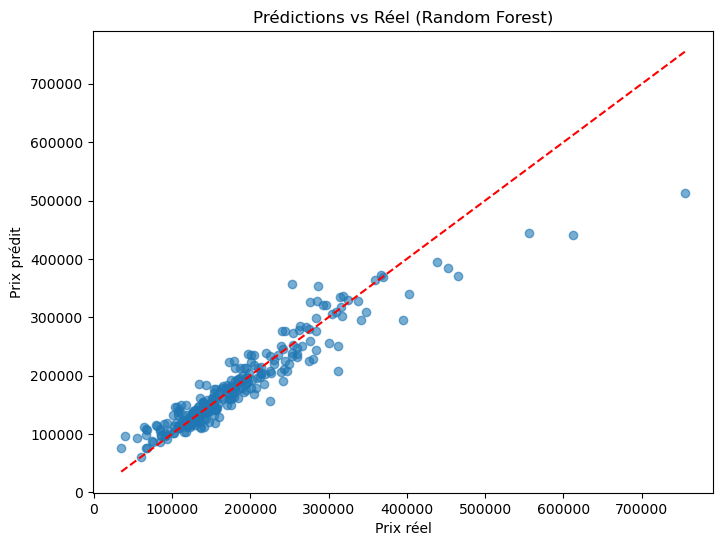

In [24]:


plt.figure(figsize=(8,6))
plt.scatter(y_valid, y_pred_best, alpha=0.6)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel("Prix réel")
plt.ylabel("Prix prédit")
plt.title(f"Prédictions vs Réel ({best_model_name})")
plt.show()


Sauvegarder les prédictions 

In [26]:
pred_df = pd.DataFrame({
    "Id": X_valid.index,
    "SalePrice_Pred": y_pred_best
})

pred_df.to_csv("../data/processed/predictions_best_model.csv", index=False)


Conclusion générale – Modélisation

Dans le cadre de ce projet de data science appliqué au jeu de données House Prices (Ames Housing Dataset), plusieurs modèles de régression ont été développés afin de prédire le prix de vente des logements à partir de leurs caractéristiques.

Une régression linéaire a d’abord été utilisée comme modèle de référence. Ce modèle obtient des performances satisfaisantes avec une erreur moyenne de prédiction (RMSE) d’environ 31 195 dollars et un coefficient de détermination R² de 0,88, indiquant qu’il explique une grande partie de la variabilité du prix de vente.

Un modèle plus complexe de type Random Forest a ensuite été entraîné afin de capturer des relations non linéaires et des interactions entre les variables explicatives. Ce modèle améliore les performances avec un RMSE d’environ 30 180 dollars et un R² de 0,88, traduisant une meilleure précision et une capacité explicative supérieure.

La comparaison des modèles montre que le Random Forest surpasse la régression linéaire, notamment grâce à sa capacité à modéliser des structures complexes dans les données. Il a donc été retenu comme modèle final pour la prédiction du prix des maisons.

Sauvegarde des modèles

In [27]:
os.makedirs("models", exist_ok=True)

# Sauvegarder les modèles dans models/

joblib.dump(rf_model, "models/rf_model.joblib")
joblib.dump(linreg_model, "models/linreg_model.joblib")

print("Modèles sauvegardé dans 'models/rf_model.joblib' et 'models/linreg_model.joblib'")

Modèles sauvegardé dans 'models/rf_model.joblib' et 'models/linreg_model.joblib'
